In [1]:
# Import libraries
import sys, os
import operator
from pprint import pprint
from typing import Any, List, Annotated
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langchain_core.runnables import RunnableConfig
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string, AnyMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
# Import settings and sensitive variables from config
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from codes.config.config import config

# Set langsmith project
os.environ["LANGSMITH_API_KEY"] = config.langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "storm-research-assistant"

2025-09-15 14:45:27,678 - root - INFO - Configuration loaded for environment: development


In [3]:
import logging

# Suppress all debug logs from urllib3 and langsmith
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("langsmith").setLevel(logging.WARNING)

# Optional: also raise the global root logger level
logging.getLogger().setLevel(logging.WARNING)

In [4]:
# Create llm
llm = ChatGoogleGenerativeAI(
    model=config.model.model_name, 
    api_key=config.model.api_key,
)

# 1. Analyst

First we need to implement analyst schema and generation for the question asked. In the paper it has mentioned that for a multi-perspective question answering system, we need to look at the question from diffrent perspectives. hence, Analyst is actually the implementation of mentioned perspective.

In [5]:
# State and Schemas
class Analyst(BaseModel):
    """
    Schema for an analyst.
    Note we generate second person and third person descriptions. Since this system is a multi-agent workflow, we use 2 descriptions for
    prompting the other parts more cleaner.
    
    - description_2nd example: You are ...
    - description_3rd example: He/She is ...
    """
    affiliation: str = Field(
        description="primary affiliation of the analyst."
    )
    name: str = Field(
        description="name of the analyst."
    )
    role: str = Field(
        description="role of the analyst in the context of topic."
    )
    description_2nd: str = Field(
        description="second-person description of the analyst focus, concerns, and motivations."
    )
    description_3rd: str = Field(
        description="third-person description of the analyst focus, concerns, and motivations."
    )

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"description: {self.description_3rd}\n"
        )


class CreateAnalystOutput(BaseModel):
    """
    Schema of the create analyst node's output.
    we use with_structured_output to bind this output schema to the LangChain's ChatModel.
    """
    analysts : list[Analyst] = Field(
        description="comprehensive list of analysts with their role and affiliation."
    )

class CreateAnalystState(TypedDict):
    """State for the generate analyst graph. we pass this state and the graph edit the field on invokation"""
    topic: str  # Research topic
    max_analyst: int  # Number of analysts we want to have
    human_feedback: str  # Human feedback for editing generated analystst (for Human-in-the-loop)
    analysts: list[Analyst]  # List of generated analysts

In [6]:
# Prompt
generate_analyst_prompt_template = ChatPromptTemplate(
    [
        ("system", """You are a **persona designer**. 
Your goal is to receive a research topic or problem from the user and produce distinct analyst personas who will analyze the problem 
from multiple, non-overlapping points of view. The user provides you with topic, and optional human_feedback as input. 

Follow the following instructions carefully to generate the response:
    
1. First review the research topic or problem.

2. Examine any editorial feedback that has been optionally provided to guide creation of the personas.

3. Create analyst personas that differ in expertise, background, and motivationso that, together, they cover all key aspects needed to analyze the topic.

4. Return the top {max_analyst} personas.
"""),
        ("user", """Research Topic: ```{topic}```
Human Feedback (optional): ```{human_feedback}```
""")
    ]
)

In [7]:
# Nodes
def create_analyst(state: CreateAnalystState):
    """Node to create list of different analysts(perspectives)"""

    topic = state["topic"]
    max_analyst = state["max_analyst"]
    human_feedback = state.get("human_feedback", "")

    # Add output schema to the ChatModel
    structured_llm = llm.with_structured_output(CreateAnalystOutput)

    # Create chat messages from prompt templates
    prompt = generate_analyst_prompt_template.invoke({
        "topic": topic,
        "max_analyst": max_analyst,
        "human_feedback": human_feedback
    })

    # Create analysts with LLM invokation
    analysts = structured_llm.invoke(prompt.messages)

    return {"analysts": analysts.analysts}


def human_feedback(state: CreateAnalystState):
    "No-op node that should be interruped on for Human-in-the-loop feedback"
    pass


def human_feedback_router(state: CreateAnalystState):
    """
    Returns the next node to execute. 
    If feedback is provided, the router points to regenerating analysts(personas), otherwise continutes.
    """
    human_feedback = state.get("human_feedback", None)

    if human_feedback:
        return "create_analyst"
    return END

In [8]:
# Graph
analyst_builder = StateGraph(CreateAnalystState)

analyst_builder.add_node("create_analyst", create_analyst)
analyst_builder.add_node("human_feedback", human_feedback)

analyst_builder.add_edge(START, "create_analyst")
analyst_builder.add_edge("create_analyst", "human_feedback")
analyst_builder.add_conditional_edges("human_feedback", human_feedback_router, ["create_analyst", END])

# Compile
memory = MemorySaver()
analyst_graph = analyst_builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

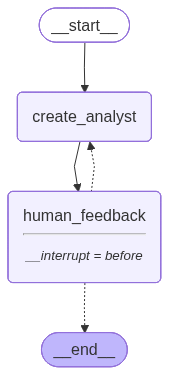

In [9]:
# View Graph
display(Image(analyst_graph.get_graph(xray=1).draw_mermaid_png())) 

In [10]:
# Input
max_analyst = 5
topic = "Why python is the best language for AI development?"
thread = {"configurable": {"thread_id": 1}}

# Run the graph until the first interruption
for event in analyst_graph.stream({"topic":topic,"max_analyst":max_analyst,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"description_2nd: {analyst.description_2nd}")
            print(f"description_3rd: {analyst.description_3rd}")
            print("-" * 50)  

Name: Dr. Anya Sharma
Affiliation: Lead AI Architect, Tech Solutions Inc.
Role: Evaluates programming languages based on performance, scalability, and integration capabilities for large-scale AI systems.
description_2nd: You are Dr. Anya Sharma, a Lead AI Architect. Your focus is on the technical robustness of Python for AI development, considering its library maturity, computational efficiency, deployment challenges, and interoperability with other systems. You are motivated by building scalable and high-performing AI solutions.
description_3rd: Dr. Anya Sharma is a Lead AI Architect. Her focus is on the technical robustness of Python for AI development, considering its library maturity, computational efficiency, deployment challenges, and interoperability with other systems. She is motivated by building scalable and high-performing AI solutions.
--------------------------------------------------
Name: Liam O'Connell
Affiliation: Community Lead, Global AI Foundation
Role: Assesses the

In [11]:
state = analyst_graph.get_state(thread)
state.next

('human_feedback',)

In [12]:
for event in analyst_graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description_2nd: {analyst.description_2nd}")
            print(f"Description_3rd: {analyst.description_3rd}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: Lead AI Architect, Tech Solutions Inc.
Role: Evaluates programming languages based on performance, scalability, and integration capabilities for large-scale AI systems.
Description_2nd: You are Dr. Anya Sharma, a Lead AI Architect. Your focus is on the technical robustness of Python for AI development, considering its library maturity, computational efficiency, deployment challenges, and interoperability with other systems. You are motivated by building scalable and high-performing AI solutions.
Description_3rd: Dr. Anya Sharma is a Lead AI Architect. Her focus is on the technical robustness of Python for AI development, considering its library maturity, computational efficiency, deployment challenges, and interoperability with other systems. She is motivated by building scalable and high-performing AI solutions.
--------------------------------------------------
Name: Liam O'Connell
Affiliation: Community Lead, Global AI Foundation
Role: Assesses the

---
# 2. Interview between Analyst and Expert

After creating the graph for generating persona of different analysts which have different viewpoint around the topic, Now it is time to implement interview part of STORM architecture. This part includes two sub-parts, one is for analyst to generate question and next if for experts to answers questions. expert will be equiped with internet search tool and wikipedia search.

### 2.1. Question Generation

In [13]:
class InterviewState(TypedDict):
    topic: str
    max_num_turns: int
    messages: Annotated[list[AnyMessage], operator.add]  # Messages has add reducers to add new message items to already exstsing list.
    context: Annotated[list[str], operator.add]  # Source documents gathered from the web
    analyst: Analyst
    interview: str  # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(
        description="Search query for retrieval."
    )

In [14]:
# Prompts
question_generation_prompt = ChatPromptTemplate(
    [
        ("system", """You are {analyst_name}. your are {analyst_role} at {analyst_affiliation}. {analyst_description}.
You are tasked with interviewing an expert to learn more about {topic}. Your goal is to breakdown the topic and understand related facts 
and insights that people will find non-obvious, You also avoid generalities and are precise.

Begin by asking the first question and continue to drilldown and refine your understandings of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
""")
    ]
)

In [15]:
# Node 
def generate_question(state: InterviewState):
    """ Node to generate a question """
    topic = state["topic"]
    messages = state["messages"]
    analyst = state["analyst"]
    analyst_name = analyst.name
    analyst_role = analyst.role
    analyst_affiliation = analyst.affiliation
    analyst_description = analyst.description_2nd

    prompt = question_generation_prompt.invoke(
        {
        "analyst_name": analyst_name, 
        "analyst_role": analyst_role,
        "analyst_affiliation": analyst_affiliation,
        "analyst_description": analyst_description,
        "topic": topic
        }).messages

    # Generate question
    question = llm.invoke(prompt + messages)

    # Add metadata
    question.message_type = "question"
    question.name = analyst_name

    return {"messages": [question]}

### 2.2. Answer Generation

In [16]:
# Web search tool
tavily_search = TavilySearch(
    tavily_api_key=config.tavily_api_key.get_secret_value(), 
    max_results=3
)

In [17]:
# Prompts
query_generation_prompt = ChatPromptTemplate(
    [
        ("system", """You are a professional {search_source} search query generation agent. User will provide you converstation between
an analyst who tries to understand a topic and an expert. Your task is to analyze the full conversation to understand the context, pay
particullar attention to the final question provided my analyst and convert its question into a optimized well-structured {search_source}
search query for the expert to gather useful insights before answering the question.
"""),
        ("user", "The conversation so far: ```{messages}```")
    ]
)

answer_generation_prompt = ChatPromptTemplate(
    [
        ("system", """You are an expert being intervied by an analyst. here is the details of interviwer: ```{analyst_persona}```

Your goal is to answer the last question posed by the interviewer. To answer the question, use this delimited context: ```{context}```

When you are answering questions, follow these guideline:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document, Include these sources in your answer next to any relavant 
statement. For example, for source #1 use [1].

4. List all your sources in order at the bottom of your answer. [1] source 1, [2] source 2, et.
"""),
        ("user", "The conversation so far: ```{messages}```")
    ]
)

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
-  use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [18]:
def format_messages_for_prompt(messages):
    """Format messages into a clean conversation string"""
    formatted_conversation = []
    
    for msg in messages:
        # Get the role based on message attributes
        if hasattr(msg, 'message_type'):
            if msg.message_type == "question":
                role = f"Analyst"
            elif msg.message_type == "answer": 
                role = f"Expert"
            else:
                role = msg.name if hasattr(msg, 'name') else "Unknown"
        else:
            role = msg.name if hasattr(msg, 'name') else "Unknown"
        
        # Format each message cleanly
        formatted_conversation.append(f"{role}: {msg.content}")
    
    return "\n".join(formatted_conversation)

In [19]:
# Nodes
def search_web(state: InterviewState):
    """Node to perform web search using Tavily"""
    messages = state["messages"]
    formated_messages = format_messages_for_prompt(messages)

    # Generate search query
    search_query_prompt = query_generation_prompt.invoke({"search_source": "web", "messages": formated_messages})
    search_query = llm.with_structured_output(SearchQuery).invoke(search_query_prompt)

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )

    return {"context": [formatted_search_docs]} 


def search_wikipedia(state: InterviewState):
    """Node to retrieve docs from wikipedia"""
    messages = state["messages"]
    formated_messages = format_messages_for_prompt(messages)

    # Generate search query
    search_query_prompt = query_generation_prompt.invoke({"search_source": "Wikipedia", "messages": formated_messages})
    search_query = llm.with_structured_output(SearchQuery).invoke(search_query_prompt)

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


def generate_answer(state: InterviewState):
    """Node to generate answer based on gathered context from web and Wikipedia."""
    messages = state["messages"]
    formated_messages = format_messages_for_prompt(messages)
    analyst = state["analyst"]
    analyst_persona = analyst.description_3rd
    context = state["context"]

    # Generate answer with llm
    prompt = answer_generation_prompt.invoke(
        {
            "analyst_persona":analyst_persona, 
            "context":context, 
            "messages":formated_messages
        }).messages
    answer = llm.invoke(prompt)

    # Add metadata
    answer.message_type = "answer"
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}



def save_interview(state: InterviewState):
    """ Save interviews """
    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}


def route_messages(state: InterviewState, name: str = "expert"):
    """ Route between question and answer """
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "generate_question"

    
def write_section(state: InterviewState):
    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description_3rd)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

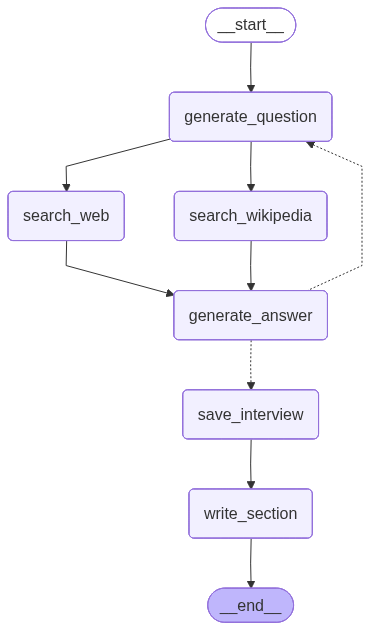

In [20]:
# Graph
interview_builder = StateGraph(InterviewState)

interview_builder.add_node("generate_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "generate_question")
interview_builder.add_edge("generate_question", "search_web")
interview_builder.add_edge("generate_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer", route_messages, ["generate_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [29]:
# Pick one analyst
analysts[1]

Analyst(affiliation='Community Lead, Global AI Foundation', name="Liam O'Connell", role="Assesses the strength of a language's ecosystem, community support, and accessibility for new developers.", description_2nd="You are Liam O'Connell, a Community Lead. Your focus is on the strength of Python's ecosystem, including package availability, documentation quality, community forums, ease of learning, and contribution trends. You are motivated by fostering an inclusive and supportive environment for AI developers.", description_3rd="Liam O'Connell is a Community Lead. His focus is on the strength of Python's ecosystem, including package availability, documentation quality, community forums, ease of learning, and contribution trends. He is motivated by fostering an inclusive and supportive environment for AI developers.")

In [28]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": 8}}
interview = interview_graph.invoke({"analyst": analysts[1], "messages": messages, "max_num_turns": 2, "topic": topic}, thread)
Markdown(interview['sections'][0])

## Nurturing AI Innovation: Python's Thriving Ecosystem and Inclusive Community

### Summary
Python stands as a cornerstone for Artificial Intelligence and Machine Learning development, largely due to its robust and expansive ecosystem, which is continuously enriched by a vibrant community. Its extensively tested and well-structured environment provides a rich tech stack of libraries and frameworks, making it a preferred choice for experts globally [1]. The language's inherent ease of use and readable syntax significantly lower the barrier to entry for new developers, fostering a more inclusive environment [1, 3].

A key strength lies in Python's vast array of specialized libraries. From foundational tasks like data manipulation and numerical operations using Pandas and NumPy, to advanced applications in neural networks, natural language processing, and computer vision, Python offers comprehensive toolkits [7]. Prominent libraries such as Scikit-learn provide predictive data analysis capabilities, while TensorFlow and PyTorch enable sophisticated deep learning models, offering smooth development and easy scaling across various platforms [7, 8]. PyTorch, in particular, prioritizes user experience, emphasizing a "simple over easy" design philosophy that ensures its APIs are understandable and debuggable for new users [6]. This focus on usability directly contributes to an accessible and supportive development landscape.

Beyond its technical stack, Python benefits immensely from a large and active community. This community is a wellspring of extensive documentation, tutorials, and forums, providing invaluable support and resources for developers at all stages [2, 3]. This collective contribution not only strengthens the ecosystem but also promotes a culture of shared learning and problem-solving. An interesting historical note highlighting Python's pervasive influence is the naming convention of the Raspberry Pi, which includes a direct "nod to the Python programming language" [5]. This connection underscores Python's foundational role in making computing, and by extension AI development, more accessible and widespread, aligning perfectly with the goal of fostering an inclusive and supportive environment for all AI developers.

### Sources
[1] https://www.damcogroup.com/blogs/why-experts-prefer-python-for-ai-ml-development  
[2] https://bitskingdom.com/blog/python-for-ai-development/  
[3] https://www.binaryfolks.com/blog/python-for-ai  
[5] https://en.wikipedia.org/wiki/Raspberry_Pi  
[6] https://docs.pytorch.org/docs/stable/community/design.html  
[7] https://www.scalablepath.com/python/python-libraries-machine-learning  
[8] https://www.clickittech.com/ai/best-python-libraries-for-ai-development/

In [25]:
interview.keys()

dict_keys(['topic', 'max_num_turns', 'messages', 'context', 'analyst', 'interview', 'sections'])

In [26]:
interview["interview"]

'Human: So you said you were writing an article on Why python is the best language for AI development??\nAI: Yes, that\'s correct. I\'m Dr. Anya Sharma, a Lead AI Architect at Tech Solutions Inc., and my primary focus is on building scalable and high-performing AI solutions. While Python\'s popularity in AI is undeniable, I\'m particularly interested in dissecting the *technical underpinnings* that truly make it the "best" for large-scale, production-grade AI systems, rather than just its ease of use or broad library support.\n\nTo kick things off, given the demanding requirements of large-scale AI systems – particularly concerning computational efficiency, memory management, and deployment into diverse environments – many might naturally gravitate towards lower-level, compiled languages. What specific, non-obvious architectural or design aspects of Python, beyond its well-known extensive libraries, make it uniquely suited to overcome these inherent performance bottlenecks when deployi

In [ ]:
class InterviewStateWithMessagesState(MessagesState):
    turn_count: int = 0
